#### Set up and Pre-processing

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
from sklearn.preprocessing import MinMaxScaler
from pyod.models.vae import VAE
import torch
from torch.utils.data import DataLoader, TensorDataset


f = np.load("C:/Users/apekx/Desktop/thesis/datas/datas/AIonosphere.npz")  
x_train, x_test, y_test = f["x"], f["tx"], f["ty"]


scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test = y_test.astype(int)



#### Finding best threshold
- to choose the best decision threshold for classifying anomalies based on the F1 score, rather than using a fixed threshold

In [191]:
def find_best_f1_threshold(y_true, scores):
    thresholds = np.linspace(0, 1, 200)
    best_f1 = 0
    best_thresh = 0.5
    for t in thresholds:
        preds = (scores >= t).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    return best_thresh, best_f1


#### Normal Vae with default parameters

In [192]:
def run_normal_vae_default(x_train, x_test, y_test):
    vae = VAE(
        contamination=0.1,
        encoder_neuron_list=[128, 64, 32],
        decoder_neuron_list=[32, 64, 128],
        latent_dim=2,
        epoch_num=50,
        batch_size=32,
        lr=0.001,
        dropout_rate=0.1,
        beta=1.0,
        verbose=0
    )

    start_train = time.time()
    vae.fit(x_train)
    train_time = time.time() - start_train

    start_infer = time.time()
    scores = vae.decision_function(x_test)
    inference_time = time.time() - start_infer

    scores = (scores - scores.min()) / (scores.max() - scores.min())
    roc = roc_auc_score(y_test, scores)
    precision, recall, _ = precision_recall_curve(y_test, scores)
    pr = auc(recall, precision)
    thresh, f1 = find_best_f1_threshold(y_test, scores)

    print(f"Normal VAE (Default) ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}, Train Time: {train_time:.2f}s, Inference Time: {inference_time:.2f}s")

    return {
        "model": "NormalVAE_Default",
        "roc_auc": roc,
        "pr_auc": pr,
        "train_time": train_time,
        "inference_time": inference_time,
        "threshold": thresh,
        "f1_score": f1,
        "scores": scores
    }

result_normal_default = run_normal_vae_default(x_train_scaled, x_test_scaled, y_test)


Normal VAE (Default) ROC AUC: 0.9452, PR AUC: 0.9279, Train Time: 14.69s, Inference Time: 0.02s


#### Normal Vae with overcomplete Parameters

In [193]:
def run_overcomplete_vae_default(x_train, x_test, y_test):
    vae = VAE(
        contamination=0.1,
        encoder_neuron_list=[128, 64, 32],
        decoder_neuron_list=[32, 64, 128],
        latent_dim=100,
        epoch_num=100,
        batch_size=32,
        lr=0.0005,
        dropout_rate=0.1,
        beta=1.0,
        verbose=0
    )

    start_train = time.time()
    vae.fit(x_train)
    train_time = time.time() - start_train

    start_infer = time.time()
    scores = vae.decision_function(x_test)
    inference_time = time.time() - start_infer

    scores = (scores - scores.min()) / (scores.max() - scores.min())
    roc = roc_auc_score(y_test, scores)
    precision, recall, _ = precision_recall_curve(y_test, scores)
    pr = auc(recall, precision)
    thresh, f1 = find_best_f1_threshold(y_test, scores)

    print(f"Overcomplete VAE ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}, Train Time: {train_time:.2f}s, Inference Time: {inference_time:.2f}s")

    return {
        "model": "OvercompleteVAE_Default",
        "roc_auc": roc,
        "pr_auc": pr,
        "train_time": train_time,
        "inference_time": inference_time,
        "threshold": thresh,
        "f1_score": f1,
        "scores": scores
    }

result_ocvae = run_overcomplete_vae_default(x_train_scaled, x_test_scaled, y_test)


Overcomplete VAE ROC AUC: 0.9466, PR AUC: 0.9285, Train Time: 35.98s, Inference Time: 0.03s


In [194]:
import sys
sys.path.append("C:/Users/apekx/Desktop/thesis/datas/hvae")

from train_eval import train_models, evaluate_model


#### Hierarchical VAE with Hyperparameters

In [203]:
def run_hvae_default(x_train, x_test, y_test):
    input_dim = x_train.shape[1]

    start_train = time.time()
    results = train_models(
        X_train=x_train,
        X_test=x_test,
        y_test=y_test,
        input_dim=input_dim,
        z1_list=[16],
        z2_list=[2],
        epoch_list=[200],
        optimizer_type="adam"
    )
    end_train = time.time()
    train_time = end_train - start_train

    best_result = results[0]
    model = best_result["model"]

    X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    start_infer = time.time()
    recon_errors, _ = evaluate_model(model, X_test_tensor, y_test)
    threshold, best_f1 = find_best_f1_threshold(y_test, recon_errors)
    print(f"HVAE_Default - Optimal Threshold: {threshold:.4f}, Best F1 Score: {best_f1:.4f}")



    end_infer = time.time()
    inference_time = end_infer - start_infer

    roc_auc = best_result["auc"]
    precision, recall, _ = precision_recall_curve(y_test, recon_errors)
    pr_auc = auc(recall, precision)

    print(f"Hierarchical VAE (Hyperparameters) - ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, "
          f"Train Time: {train_time:.2f}s, Inference Time: {inference_time:.2f}s")

    return {
        "model": "HVAE_Default",
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "scores": recon_errors,
        "train_time": train_time,
        "inference_time": inference_time,
        "threshold": threshold,
       "f1_score": best_f1

    }

result_hvae = run_hvae_default(x_train_scaled, x_test_scaled, y_test)


z1: 16, z2: 2, epochs: 200, opt: ADAM → AUC: 0.7800
HVAE_Default - Optimal Threshold: 0.1055, Best F1 Score: 0.6862
Hierarchical VAE (Hyperparameters) - ROC AUC: 0.7800, PR AUC: 0.6527, Train Time: 41.35s, Inference Time: 0.73s


In [204]:
result_normal_default = run_normal_vae_default(x_train_scaled, x_test_scaled, y_test)
result_ocvae = run_overcomplete_vae_default(x_train_scaled, x_test_scaled, y_test)
result_hvae = run_hvae_default(x_train_scaled, x_test_scaled, y_test)


Normal VAE (Default) ROC AUC: 0.9452, PR AUC: 0.9279, Train Time: 21.37s, Inference Time: 0.03s
Overcomplete VAE ROC AUC: 0.9466, PR AUC: 0.9285, Train Time: 40.64s, Inference Time: 0.03s
z1: 16, z2: 2, epochs: 200, opt: ADAM → AUC: 0.7763
HVAE_Default - Optimal Threshold: 0.1005, Best F1 Score: 0.7076
Hierarchical VAE (Hyperparameters) - ROC AUC: 0.7763, PR AUC: 0.7216, Train Time: 44.57s, Inference Time: 0.92s


In [197]:
results = [result_normal_default, result_ocvae, result_hvae]
df_results = pd.DataFrame(results)
df_results


,model,roc_auc,pr_auc,train_time,inference_time,threshold,f1_score,scores
0,NormalVAE_Default,0.945248,0.927945,16.246516,0.018449,0.070352,0.892128,"[0.05747689, 0.024680445, 0.018686958, 0.08205..."
1,OvercompleteVAE_Default,0.946636,0.928524,33.284069,0.021482,0.070352,0.895349,"[0.060577415, 0.02474104, 0.019591346, 0.08340..."
2,HVAE_Default,0.809046,0.654717,27.720654,0.527563,0.100503,0.705628,"[0.08062284597070972, 0.03630530837480665, 0.2..."


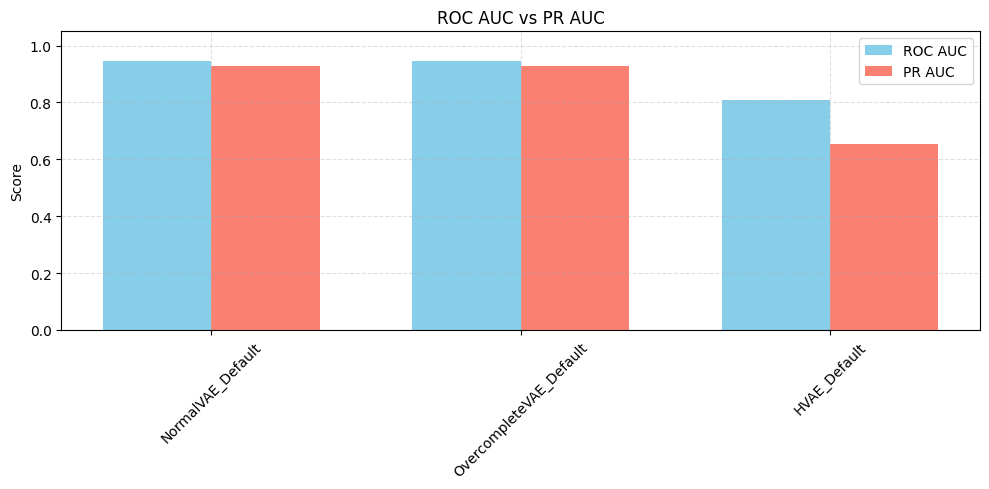

In [198]:
x = np.arange(len(df_results))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, df_results["roc_auc"], width, label="ROC AUC", color="skyblue")
plt.bar(x + width/2, df_results["pr_auc"], width, label="PR AUC", color="salmon")
plt.xticks(x, df_results["model"], rotation=45)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("ROC AUC vs PR AUC")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [199]:
df_results.to_csv("vae_benchmark_default.csv", index=False)
print("Benchmark exported to vae_benchmark_default.csv")


Benchmark exported to vae_benchmark_default.csv


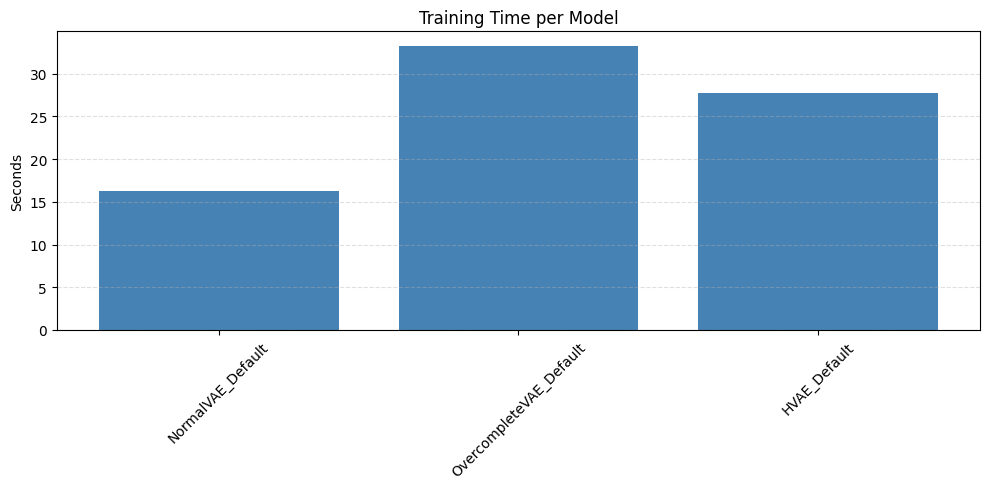

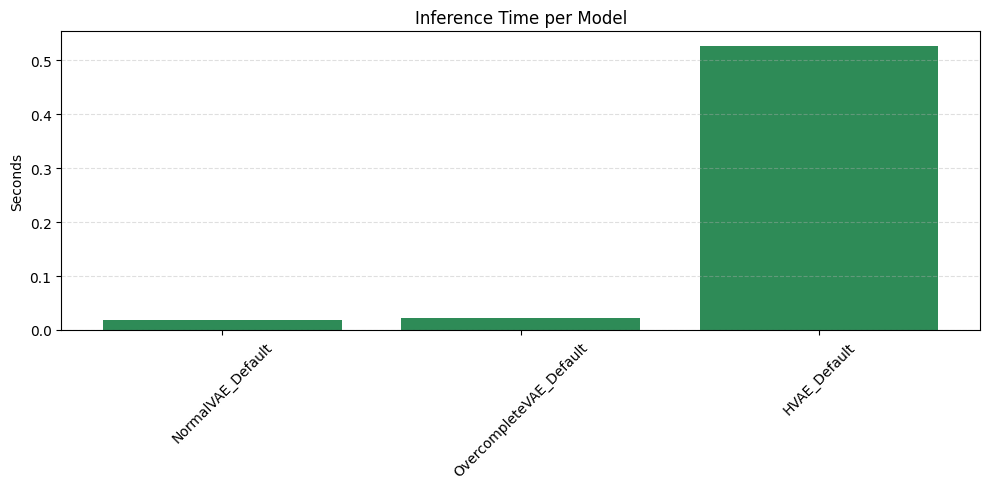

In [200]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df_results))
width = 0.35

# Training Time Plot
plt.figure(figsize=(10, 5))
plt.bar(x, df_results["train_time"], color="steelblue")
plt.xticks(x, df_results["model"], rotation=45)
plt.ylabel("Seconds")
plt.title("Training Time per Model")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Inference Time Plot
plt.figure(figsize=(10, 5))
plt.bar(x, df_results["inference_time"], color="seagreen")
plt.xticks(x, df_results["model"], rotation=45)
plt.ylabel("Seconds")
plt.title("Inference Time per Model")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [201]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest

baseline_models = {
    "kNN" : KNN(),
    "Isolation Forest" : IForest()
}

results_baseline = []

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")

    if name == "AutoEncoder":
        model.fit(x_train_scaled, epochs=50, verbose=0, hidden_neurons=[64, 32, 64])
    else:
        model.fit(x_train_scaled)

    scores = model.decision_function(x_test_scaled)

    roc = roc_auc_score(y_test, scores)
    precision, recall, _ = precision_recall_curve(y_test, scores)
    pr = auc(recall, precision)

    results_baseline.append({
        "Model": name,
        "ROC AUC": roc,
        "PR AUC": pr
    })

    print(f"{name} ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")


Training kNN...
kNN ROC AUC: 0.9444, PR AUC: 0.9410

Training Isolation Forest...
Isolation Forest ROC AUC: 0.9611, PR AUC: 0.9582


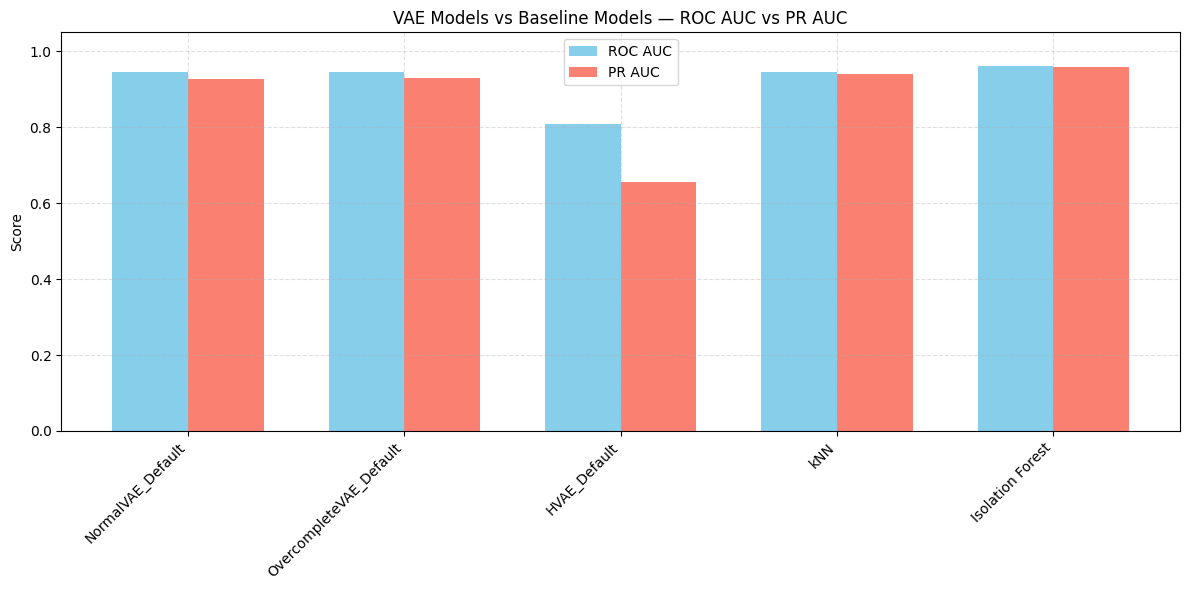

In [202]:
df_vae = pd.DataFrame(results)  
df_baseline = pd.DataFrame(results_baseline) 

df_baseline.columns = ["model", "roc_auc", "pr_auc"]

df_all = pd.concat([df_vae, df_baseline], ignore_index=True)

x = np.arange(len(df_all))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_all["roc_auc"], width, label="ROC AUC", color="skyblue")
plt.bar(x + width/2, df_all["pr_auc"], width, label="PR AUC", color="salmon")

plt.xticks(x, df_all["model"], rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("VAE Models vs Baseline Models — ROC AUC vs PR AUC")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("vae_vs_baselines_auc.png", dpi=300)
plt.show()
